In [312]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib
from matplotlib import pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import hyperopt as hp
from hyperopt import fmin, tpe, hp, space_eval, STATUS_OK
from functools import partial
import json
from catboost import Pool, CatBoostRegressor
from sklearn.linear_model import  LogisticRegression

In [257]:
data = pd.read_csv("source.post.csv")
shuffle = np.random.permutation(len(data))
data = data.iloc[shuffle]

In [258]:
feature_columns = [ 'column_1', 'column_2', 'column_3', 'column_4', 'column_5',
       'column_6', 'column_7', 'column_8', 'column_9', 'column_10']

In [216]:
col_unique_num = {}
for col in feature_columns:
    col_unique_num[col] = (len(data[col].unique()))

In [217]:
print(col_unique_num.values())

dict_values([500, 409529, 137, 4, 4, 399, 7, 35, 686, 463])


In [218]:
from sklearn.preprocessing import LabelEncoder
label_encoders = []
for col in ['column_4','column_7','column_5']:
    LE = LabelEncoder()
    label_encoders.append(LE)
    data[col] = LE.fit_transform(data[col])
    data[col] = data[col].astype('category')

In [219]:
from category_encoders import TargetEncoder

In [220]:
target_encoders = {}
for col in feature_columns:
    if col_unique_num[col] > 10:
        print(col)
        TE = TargetEncoder()
        target_encoders[col] = TE
        data[col] = TE.fit_transform(data[col], data['score'])

column_1


/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


column_2
column_3
column_6
column_8
column_9
column_10


In [221]:
data_x = pd.get_dummies(data[feature_columns])

In [222]:
data_y = data['score']

In [297]:
train_data_size = int(0.6 * len(data))
val_data_size = int(0.2 * len(data))

# train_data = data.iloc[:train_data_size]
# val_data = data.iloc[train_data_size:train_data_size + val_data_size]
# test_data = data.iloc[train_data_size + val_data_size: ]
X_train = data_x.iloc[:train_data_size]
y_train = data_y.iloc[:train_data_size].values
X_val = data_x.iloc[train_data_size:train_data_size + val_data_size]
y_val = data_y.iloc[train_data_size:train_data_size + val_data_size].values
X_test =  data_x.iloc[train_data_size + val_data_size: ]
y_test =  data_y.iloc[train_data_size + val_data_size: ].values

## LGBM

In [224]:
def lgb_model(params, lgb_train, lgb_val, boost_round=4000, 
              early_stop=20, verbose_eval=200, nfold=0,):
    print('Starting training...')
    if nfold != 0:
        lgb.cv(params, train_data, num_round = boost_roundt_round, nfold=5 )

    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=boost_round,
                valid_sets=lgb_val,
                early_stopping_rounds=early_stop, verbose_eval=200)

#     print('Saving model...')
    # save model to file
#     if model_name != '':
#         gbm.save_model('{}.txt'.format(model_name))
#     y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
#     # eval
#     print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    return gbm

In [225]:
def lgb_objective(params, lgb_train, lgb_val, X_val, y_val, fold=0):

    gbm = lgb_model(params, lgb_train, lgb_val)
    
        
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    rmse_val = mean_squared_error(y_val, y_pred) ** 0.5
    return {'loss': rmse_val ,  'status': STATUS_OK}

In [226]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

In [227]:
def hyperopt_lgb(lgb_objective, lgb_train, lgb_val, X_val, y_val):
    space = {'objective': 'regression',
             'metric':'rmse',
             'boosting':'gbdt',
             'num_leaves': hp.choice('num_leaves', list(range(20, 200, 20))),
             'feature_fraction': hp.choice('feature_fraction', [.7, .8, .9, 1]),
             'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 1),
             'learning_rate': hp.uniform('learning_rate', 0.03, 0.12),
            }
    fmin_objective = partial(lgb_objective,lgb_train=lgb_train, lgb_val=lgb_val, X_val=X_val, y_val=y_val)
    best_vals = fmin(fmin_objective, space, algo=tpe.suggest, max_evals=5)
    best_params = space_eval(space, best_vals)
    return best_params

In [228]:
best_params = hyperopt_lgb(lgb_objective, lgb_train, lgb_val, X_val, y_val)
file_name='lgb_params_target_encoder.txt'
with open(file_name, 'w') as f:
    f.write(json.dumps(best_params)) 
print(best_params)
#     file_name='{}_lgb_params_bayes_encoding.txt'.format(target)
#     with open(file_name, 'w') as f:
#         f.write(json.dumps(best_params)) 
#     print(best_params)

Starting training...                                                            
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1246                                               
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 20
[LightGBM] [Info] Start training from score 0.147496                            
Training until validation scores don't improve for 20 rounds                    
[200]	valid_0's rmse: 0.0236817                                                 
[400]	valid_0's rmse: 0.0231005                                                 
[600]	valid_0's rmse: 0.0228455                                                 
[800]	valid_0's rmse: 0.0226812                                                 
[1000]	valid_0's rmse: 0.0225

In [299]:
f = open(file_name, 'r')
dic_str = f.readline()
params = json.loads(dic_str)
f.close()
gbm = lgb_model(params, lgb_train, lgb_val, boost_round=2000)

Starting training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 20
[LightGBM] [Info] Start training from score 0.147496
Training until validation scores don't improve for 20 rounds
[200]	valid_0's rmse: 0.0230012
[400]	valid_0's rmse: 0.0225656
[600]	valid_0's rmse: 0.0223736
[800]	valid_0's rmse: 0.0222526
[1000]	valid_0's rmse: 0.0221666
[1200]	valid_0's rmse: 0.0221229
[1400]	valid_0's rmse: 0.022092
Early stopping, best iteration is:
[1453]	valid_0's rmse: 0.0220858
Starting predicting...


In [300]:
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print("rmse on test dataset: {:.4f}".format(rmse_test))

rmse on test dataset: 0.0221


In [189]:
sort_inds = np.argsort(y_test)
y_test = y_test[sort_inds]
y_pred = y_pred[sort_inds]

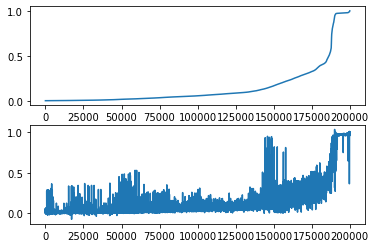

In [190]:
fig, (ax1, ax2) = plt.subplots(2, 1)
x = np.arange(len(y_test))
ax1.plot(x,  y_test, label='true')
ax2.plot(x, y_pred, label='pred')

<Figure size 864x432 with 0 Axes>

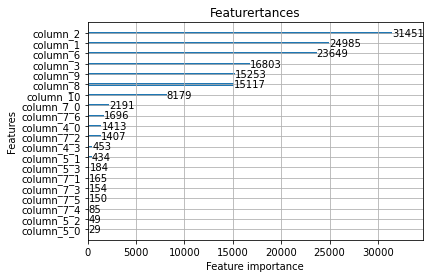

In [301]:
plt.figure(figsize=(12,6))
lgb.plot_importance(gbm, max_num_features=30)
plt.title("Featurertances")
plt.show()

## Catboost

In [259]:
cab_feature_cols = feature_columns

In [276]:
train_data_size = int(0.6 * len(data))
val_data_size = int(0.2 * len(data))
X_train_cab = data.iloc[:train_data_size][feature_columns]
y_train_cab = data.iloc[:train_data_size]['score']
X_val_cab = data.iloc[train_data_size:train_data_size+val_data_size][feature_columns]
y_val_cab = data.iloc[train_data_size:train_data_size+val_data_size]['score']
X_test_cab = data.iloc[train_data_size+val_data_size:][feature_columns]
y_test_cab = data.iloc[train_data_size+val_data_size:]['score']

In [277]:
categorical_features_indices = np.where(X_train_cab.dtypes != float)[0]

In [278]:
def cab_objective(params, X_train, y_train, categorical_features_indices):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='RMSE',
        random_seed=42,
        verbose=False,
        loss_function='RMSE',
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params()
    )
    mean_rmse = cv_data['test-RMSE-mean']
    
    return mean_rmse # as hyperopt minimises

In [279]:
def hyperopt_cab(hyperopt_objective, X_train, y_train, categorical_features_indices):
    params_space = {
        'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
        'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    }

    
    fmin_obj = partial(hyperopt_objective, X_train=X_train, y_train=y_train, 
                       categorical_features_indices=categorical_features_indices)
    best = hyperopt.fmin(
        hyperopt_objective,
        space=params_space,
        algo=hyperopt.tpe.suggest,
        max_evals=50,
        rstate=RandomState(123)
    )
    print(best)


In [280]:
cat_params = {
#     'colsample_bylevel': 0.8,
    'reg_lambda': 10,
    'iterations': 5000,
    'learning_rate': 0.5,
    'eval_metric': 'RMSE',
    'random_seed': 1111,
#     'logging_level': 'Silent',
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 40,
    'task_type': "CPU",
    'devices': '1:3',
    'loss_function':'RMSE',
    'verbose': 200,
    'grow_policy': 'Lossguide',
    'one_hot_max_size': 5,
    'depth': 8
#     'logging_level': 'Verbose'
}

# cat_submissions = []
test_pool = Pool(X_test_cab, cat_features=categorical_features_indices)
train_pool = Pool(X_train_cab, y_train_cab, categorical_features_indices)
val_pool = Pool(X_val_cab, y_val_cab, categorical_features_indices)
# specify the training parameters 
cat_model = CatBoostRegressor(**cat_params)
#train the model
cat_model.fit(train_pool, eval_set=val_pool,plot=True)
# make the prediction using the resulting model

#     cat_sub_target_id = list(test_data['RowId'].apply(lambda x: '{}_{}'.format(x, i)).values)
#     cat_sub_target_df = pd.DataFrame({'TargetId': cat_sub_target_id, 'Target': y_pred})
#     cat_submissions.append(cat_sub_target_df)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2240108	test: 0.2246113	best: 0.2246113 (0)	total: 156ms	remaining: 12m 59s
200:	learn: 0.0754516	test: 0.0725075	best: 0.0725075 (200)	total: 15.9s	remaining: 6m 20s
400:	learn: 0.0741428	test: 0.0712471	best: 0.0712471 (400)	total: 30.2s	remaining: 5m 46s
600:	learn: 0.0737107	test: 0.0708468	best: 0.0708468 (600)	total: 41.8s	remaining: 5m 5s
800:	learn: 0.0731244	test: 0.0702510	best: 0.0702510 (800)	total: 53.7s	remaining: 4m 41s
1000:	learn: 0.0728283	test: 0.0700140	best: 0.0700140 (1000)	total: 1m 5s	remaining: 4m 20s
1200:	learn: 0.0725753	test: 0.0697946	best: 0.0697946 (1200)	total: 1m 16s	remaining: 4m 2s
1400:	learn: 0.0723667	test: 0.0696515	best: 0.0696515 (1399)	total: 1m 27s	remaining: 3m 43s
1600:	learn: 0.0721878	test: 0.0695132	best: 0.0695132 (1600)	total: 1m 37s	remaining: 3m 26s
1800:	learn: 0.0720759	test: 0.0694468	best: 0.0694468 (1800)	total: 1m 45s	remaining: 3m 7s
2000:	learn: 0.0718630	test: 0.0692736	best: 0.0692736 (2000)	total: 1m 54s	remain

In [282]:
y_pred = cat_model.predict(test_pool)
print("prediction loss: {:.8f}".format(mean_squared_error(y_test_cab, y_pred) ** 0.5))

prediction loss: 0.06765582


In [283]:
y_test = y_test_cab

## XGBoost

In [309]:
def xgb_objective(params, xgb_train, xgb_val, y_val):
    num_round = 600
    watchlist = [(xgb_val, 'eval')]
    xgb_model = xgb.train(params, xgb_train, num_round,
                          evals=watchlist,
                          verbose_eval=200)
    y_pred = xgb_model.predict(xgb_val, ntree_limit=xgb_model.best_iteration + 1)
    print("Best Iteration: ", xgb_model.best_iteration)
    rmse_val = mean_squared_error(y_val, y_pred) ** 0.5
    return {'loss': rmse_val ,  'status': STATUS_OK}

In [322]:
def hyperopt_xgb(xgb_objective, xgb_train, xgb_val, y_val):
    space = {
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(10, 20, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.1, 0.5, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'rmse',
        'objective': 'reg:squarederror',
        'nthread': 4,
        'booster': 'gbtree',
        'tree_method': 'hist',
        'silent': 1,
        'seed': 1234,
        'verbose_eval': 200
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    fmin_objective = partial(xgb_objective,xgb_train=xgb_train, xgb_val=xgb_val, y_val=y_val)
    best_vals = fmin(fmin_objective, space, algo=tpe.suggest, max_evals=10)
    best_params = space_eval(space, best_vals)
    return best_params

In [323]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_val = xgb.DMatrix(X_val, label=y_val)
best_params = hyperopt_xgb(xgb_objective, xgb_train, xgb_val, y_val)

[00:51:53] WARNING: ../src/learner.cc:573:                                      
Parameters: { "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:0.34189                                                           
[200]	eval-rmse:0.02482                                                         
[400]	eval-rmse:0.02472                                                         
[599]	eval-rmse:0.02470                                                         
Best Iteration:                                                                 
599                                                                             
  0%|                                    | 0/10 [01:05<?, ?trial/s, best loss=?]

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[00:52:58] WARNING: ../src/learner.cc:573:                                      
Parameters: { "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:0.24143                                                           
[200]	eval-rmse:0.02534                                                         
[400]	eval-rmse:0.02530                                                         
[599]	eval-rmse:0.02524                                                         
Best Iteration:                                                                 
599                                                                             
[00:54:12] WARNING: ../src/learner.cc:573:                                      
Parameters: { "silent", "verbose_eval" } might not b

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	eval-rmse:0.28124                                                           
[200]	eval-rmse:0.02462                                                         
[400]	eval-rmse:0.02457                                                         
[599]	eval-rmse:0.02455                                                         
Best Iteration:                                                                 
599                                                                             
 20%|█▌      | 2/10 [03:34<09:22, 70.26s/trial, best loss: 0.024703461889110625]

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[00:55:28] WARNING: ../src/learner.cc:573:                                      
Parameters: { "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:0.36223                                                           
[200]	eval-rmse:0.02351                                                         
[400]	eval-rmse:0.02345                                                         
[599]	eval-rmse:0.02341                                                         
 30%|██▍     | 3/10 [04:22<08:30, 72.87s/trial, best loss: 0.024547071776384845]

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Best Iteration:                                                                 
599                                                                             
[00:56:37] WARNING: ../src/learner.cc:573:                                      
Parameters: { "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:0.39287                                                           
[200]	eval-rmse:0.02545                                                         
[400]	eval-rmse:0.02535                                                         
[599]	eval-rmse:0.02526                                                         
 40%|███▏    | 4/10 [05:25<07:09, 71.61s/trial, best loss: 0.023411874638422817]

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Best Iteration:                                                                 
599                                                                             
[00:57:24] WARNING: ../src/learner.cc:573:                                      
Parameters: { "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:0.37242                                                           
[200]	eval-rmse:0.02465                                                         
[400]	eval-rmse:0.02453                                                         
[599]	eval-rmse:0.02448                                                         
 50%|████    | 5/10 [06:15<05:13, 62.70s/trial, best loss: 0.023411874638422817]

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Best Iteration:                                                                 
599                                                                             
[00:58:25] WARNING: ../src/learner.cc:573:                                      
Parameters: { "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:0.29135                                                           
[200]	eval-rmse:0.02473                                                         
[400]	eval-rmse:0.02470                                                         
[599]	eval-rmse:0.02465                                                         
Best Iteration:                                                                 
599                                                 

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	eval-rmse:0.33172                                                           
[200]	eval-rmse:0.02387                                                         
[400]	eval-rmse:0.02381                                                         
[599]	eval-rmse:0.02381                                                         
 70%|█████▌  | 7/10 [07:58<02:44, 54.96s/trial, best loss: 0.023411874638422817]

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Best Iteration:                                                                 
599                                                                             
[01:00:07] WARNING: ../src/learner.cc:573:                                      
Parameters: { "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:0.34191                                                           
[200]	eval-rmse:0.02505                                                         
[400]	eval-rmse:0.02500                                                         
[599]	eval-rmse:0.02500                                                         
Best Iteration:                                                                 
599                                                 

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



[0]	eval-rmse:0.38267                                                           
[200]	eval-rmse:0.02438                                                         
[400]	eval-rmse:0.02424                                                         
[599]	eval-rmse:0.02419                                                         
 90%|███████▏| 9/10 [09:42<00:51, 51.10s/trial, best loss: 0.023411874638422817]

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Best Iteration:                                                                 
599                                                                             
100%|███████| 10/10 [09:58<00:00, 59.89s/trial, best loss: 0.023411874638422817]


NameError: name 'target' is not defined

In [325]:
best_params

{'booster': 'gbtree',
 'colsample_bytree': 0.6000000000000001,
 'eta': 0.15000000000000002,
 'eval_metric': 'rmse',
 'gamma': 0.1,
 'max_depth': 17,
 'min_child_weight': 5.0,
 'nthread': 4,
 'objective': 'reg:squarederror',
 'seed': 1234,
 'silent': 1,
 'subsample': 0.9500000000000001,
 'tree_method': 'hist',
 'verbose_eval': 200}

In [327]:
file_name='xgb_params_target_encoding.npy'
np.save(file_name, best_params)

In [330]:
watchlist = [(xgb_val, 'valid')]
xgb_model = xgb.train(best_params, xgb_train, 1000, evals=watchlist,
                      verbose_eval=50, early_stopping_rounds=50)

[01:09:37] WARNING: ../src/learner.cc:573: 
Parameters: { "silent", "verbose_eval" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	valid-rmse:0.36223
[50]	valid-rmse:0.02382
[100]	valid-rmse:0.02361
[150]	valid-rmse:0.02355
[200]	valid-rmse:0.02351
[250]	valid-rmse:0.02350
[300]	valid-rmse:0.02348
[350]	valid-rmse:0.02347
[400]	valid-rmse:0.02345
[450]	valid-rmse:0.02344
[500]	valid-rmse:0.02342
[550]	valid-rmse:0.02341
[599]	valid-rmse:0.02341


In [333]:
xgb_test = xgb.DMatrix(X_test)
y_pred_xgb = xgb_model.predict(xgb_test, ntree_limit=xgb_model.best_iteration + 1)
print("rmse: {}".format(mean_squared_error(y_test, y_pred_xgb) ** 0.5))

/home/xiongzhongzheng/anaconda3/envs/bytecamp/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


rmse: 0.02356509712297411


## Decision

In [241]:
from DecisionModule import DecisionModuleOnline

In [334]:
n_test = len(y_test)
y_test_ordered = sorted(y_test)
S = sum(y_test)

In [335]:
online_decision = DecisionModuleOnline()

In [336]:
y_pred = y_pred_xgb

In [337]:
for drop_ratio in np.arange(0.01, 1, 0.01):
    drop_ratio = int(drop_ratio * 100) / 100 
    print(drop_ratio, sum(y_pred < online_decision.params[drop_ratio])/n)

0.01 0.012005
0.02 0.015815
0.03 0.02137
0.04 0.027175
0.05 0.032915
0.06 0.04495
0.06 0.04495
0.08 0.05663
0.09 0.06853
0.1 0.08003
0.11 0.0899
0.12 0.0984
0.13 0.10762
0.14 0.11869
0.15 0.13246
0.16 0.14201
0.17 0.152835
0.18 0.165475
0.19 0.17414
0.2 0.184525
0.21 0.19155
0.22 0.20053
0.23 0.21153
0.24 0.223675
0.25 0.237105
0.26 0.24976
0.27 0.25841
0.28 0.268365
0.29 0.279345
0.3 0.289495
0.31 0.301915
0.32 0.31285
0.33 0.326225
0.34 0.332525
0.35 0.3415
0.36 0.349735
0.37 0.35858
0.38 0.367085
0.39 0.378165
0.4 0.38741
0.41 0.400305
0.42 0.41343
0.43 0.422355
0.44 0.43259
0.45 0.439555
0.46 0.45025
0.47 0.4606
0.48 0.47368
0.49 0.484105
0.5 0.49458
0.51 0.50746
0.52 0.514335
0.53 0.524415
0.54 0.533935
0.55 0.54503
0.56 0.55677
0.57 0.56471
0.58 0.57406
0.59 0.584685
0.6 0.59539
0.61 0.604085
0.62 0.615695
0.63 0.626765
0.64 0.639355
0.65 0.65202
0.66 0.661575
0.67 0.66956
0.68 0.6822
0.69 0.695795
0.7 0.701875
0.71 0.707285
0.72 0.727125
0.73 0.733415
0.74 0.741085
0.75 0.748285

In [338]:
dropped_scores = []
drop_ratios = []
best_scores = []
for drop_ratio in np.arange(0.01, 1, 0.01):
    drop_ratio = int(drop_ratio * 100) / 100 
    indicator = np.apply_along_axis(lambda score, drop_ratio: online_decision.decide(score, drop_ratio), 0, y_pred, drop_ratio)
    dropped_ratio = sum(indicator) / n_test
    drop_ratios.append(dropped_ratio)
    dropped_score = sum(y_test[indicator])
    best_scores.append(sum(y_test_ordered[:int(n * drop_ratio)]) / S)
    dropped_scores.append(dropped_score / S)
    print("drop ratio {}, drop ratio of our model {:.4f}, dropped score of our model {:.4f}, best {:.4f}".format(drop_ratio, drop_ratios[-1], dropped_scores[-1], best_scores[-1]))

drop ratio 0.01, drop ratio of our model 0.0120, dropped score of our model 0.0001, best 0.0000
drop ratio 0.02, drop ratio of our model 0.0158, dropped score of our model 0.0002, best 0.0001
drop ratio 0.03, drop ratio of our model 0.0214, dropped score of our model 0.0002, best 0.0001
drop ratio 0.04, drop ratio of our model 0.0272, dropped score of our model 0.0003, best 0.0002
drop ratio 0.05, drop ratio of our model 0.0329, dropped score of our model 0.0004, best 0.0003
drop ratio 0.06, drop ratio of our model 0.0449, dropped score of our model 0.0006, best 0.0004
drop ratio 0.06, drop ratio of our model 0.0449, dropped score of our model 0.0006, best 0.0004
drop ratio 0.08, drop ratio of our model 0.0566, dropped score of our model 0.0008, best 0.0007
drop ratio 0.09, drop ratio of our model 0.0685, dropped score of our model 0.0010, best 0.0009
drop ratio 0.1, drop ratio of our model 0.0800, dropped score of our model 0.0012, best 0.0011
drop ratio 0.11, drop ratio of our model 

drop ratio 0.87, drop ratio of our model 0.8726, dropped score of our model 0.4275, best 0.4190
drop ratio 0.88, drop ratio of our model 0.8816, dropped score of our model 0.4472, best 0.4410
drop ratio 0.89, drop ratio of our model 0.8904, dropped score of our model 0.4676, best 0.4640
drop ratio 0.9, drop ratio of our model 0.9041, dropped score of our model 0.5020, best 0.4889
drop ratio 0.91, drop ratio of our model 0.9139, dropped score of our model 0.5284, best 0.5157
drop ratio 0.92, drop ratio of our model 0.9224, dropped score of our model 0.5521, best 0.5437
drop ratio 0.93, drop ratio of our model 0.9313, dropped score of our model 0.5799, best 0.5746
drop ratio 0.94, drop ratio of our model 0.9409, dropped score of our model 0.6166, best 0.6115
drop ratio 0.95, drop ratio of our model 0.9510, dropped score of our model 0.6752, best 0.6688
drop ratio 0.96, drop ratio of our model 0.9584, dropped score of our model 0.7241, best 0.7343
drop ratio 0.97, drop ratio of our model 

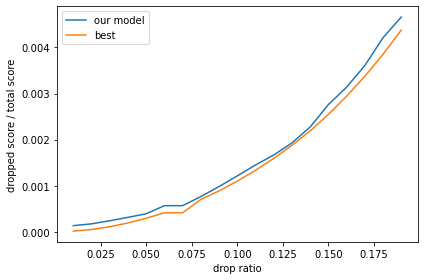

In [339]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.01, 0.2, 0.01), dropped_scores[:19], label='our model')
ax.plot(np.arange(0.01, 0.2, 0.01), best_scores[:19], label='best')
ax.set_ylabel("dropped score / total score")
ax.set_xlabel('drop ratio')
ax.legend()
fig.tight_layout()
plt.show()

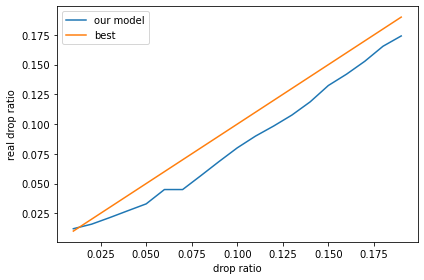

In [340]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.01, 0.2, 0.01), drop_ratios[:19], label='our model')
ax.plot(np.arange(0.01, 0.2, 0.01), np.arange(0.01, 0.2, 0.01), label='best')
ax.set_ylabel("real drop ratio")
ax.set_xlabel('drop ratio')
ax.legend()
fig.tight_layout()
plt.show()